In [1]:
# To use only Google Colab
! pip install matplotlib --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 8.8 MB/s 
     |████████████████████████████████| 965 kB 37.8 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


# Unidad II. Regresiones y reducción de dimensionalidad.

## Modelos de regresión lineales

Los modelos de regresión lineales:
- predicen una o más variable *dependientes*
- como una combinación lineal de
  - un conjunto de variables *independientes*
- $Y = \alpha + \beta_{1}X_{1} + \beta_{2}X_{2} + ... + \beta_{k}X_{k} + E$
  - $Y$ es la variable *dependiente*.
  - $X_1, X_2, ...$ son las variables *independientes*.
  - $\beta_1, \beta_2, ...$ son los *coeficientes*.
  - $\alpha$ es la ordenada al origen.
  - $E$ es un término que representa el error.
- El problema del modelo:
  - Es hallar $\alpha, \beta_1, \beta_2$
  - Esto suele hacerse mediante el criterio de cuadrados mínimos:
  - minimizar $ \sum_{i=1}^{N}(Y_{i}-\hat{Y}_{i})^{2} = \sum_{i=1}^{N} E_{i}^{2}$
- El modelo asume:
  - *Linealidad*: La variable dependiente se obtiene por una combinación lineal
    de las otras.
  - Independencia de los residuos
  - Homocedasticidad: Igualdad de varianza para cada variable independiente.
  - Normalidad: Los residuos se distribuyen de manera normal con $\mu = 0$
  - No-colinealidad: Las variables independientes no pueden ser combinaciones
    lineales unas de otras, no debe haber correlación entre ellas.

Vamos a simular un modelo lineal completo.

In [3]:
import numpy as np
import scipy.stats as st

# Simular variables aleatorias
nvars = 2
nvalues = 1000
variables = np.random.rand(nvars, nvalues)

# Simular la intersección
alpha = np.random.rand()

# Simulación de los coeficientes
betas = np.random.rand(nvars)

# simular los errores
errors = 0.05 * st.norm.rvs(size=nvalues)

In [11]:
model = alpha + np.matmul(betas, variables)  + errors
model[:4]


array([1.63720797, 0.94779458, 1.5161354 , 1.58971091])

In [12]:
import statsmodels.api as sm

exog = sm.add_constant(variables.T)

# Ordinal Least Square
reg_mod = sm.OLS(
    endog = model,
    exog = exog
)

fitted = reg_mod.fit()


In [13]:
# alpha, beta1, beta2
print(f"Fitted coefficients: {fitted.params}")
print(f"Real coefficients: {[alpha, betas]}")


Fitted coefficients: [0.76109845 0.8500342  0.17290346]
Real coefficients: [0.7627757981377125, array([0.85494351, 0.16427632])]


In [14]:
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                 1.201e+04
Date:                Sat, 26 Nov 2022   Prob (F-statistic):               0.00
Time:                        15:32:56   Log-Likelihood:                 1552.2
No. Observations:                1000   AIC:                            -3098.
Df Residuals:                     997   BIC:                            -3084.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7611      0.004    177.737      0.000       0.753       0.770
x1             0.8500      0.006    152.157      0.000       0.839       0.861
x2             0.1729      0.006     30.820      0.000       0.162       0.184
==============================================================================
Omnibus:                        1.901   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.387   Jarque-Bera (JB):                1.763
Skew:                           0.008   Prob(JB):                        0.414
Kurtosis:                       2.795   Cond. No.                         5.28
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
var_with_intercept = sm.add_constant(variables.T)
print("Variables with estimated alpha:")
print(var_with_intercept[:4,:])

print(f"predicted:\n{fitted.predict(var_with_intercept[:4,:])}")
print(f"Real values:\n{model[:4]}")


Variables with estimated alpha:
[[1.         0.33919747 0.02766105]
 [1.         0.68698863 0.90822611]
 [1.         0.78263511 0.4105387 ]
 [1.         0.89299157 0.2699141 ]]
predicted:
[0.68780517 1.46386622 1.18377432 1.14984092]
Real values:
[0.68337303 1.38371137 1.21937544 1.1281875 ]


Text(0.5, 1.0, 'Coeficiente de determinación: $R^2 = 0.963$')

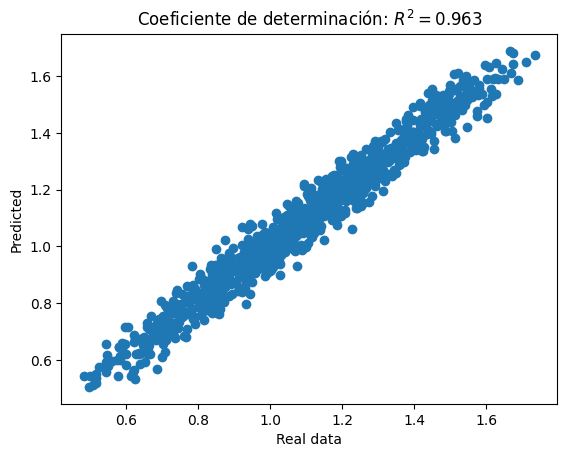

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(
    model,
    fitted.predict(var_with_intercept)
)
plt.xlabel("Real data")
plt.ylabel("Predicted")
plt.title(f"Coeficiente de determinación: $R^2 = {fitted.rsquared:0.3f}$")

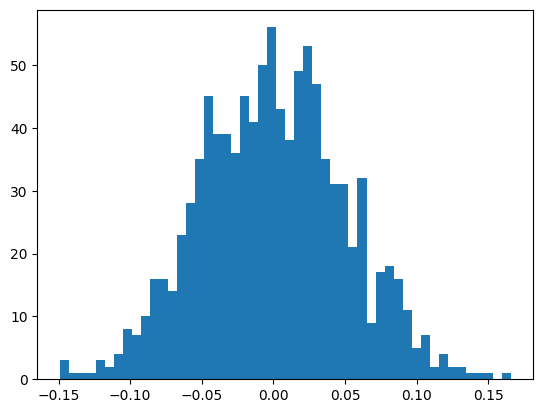

In [ ]:
_ = plt.hist(fitted.resid, bins = 50)

### Coeficientes de determinación

Es el valor $R^2$ de la regresión. 
- Es la proporción de la varianza de la variables de respuesta que puede ser
  predicha a partir de las variables explicativas.
- Varía entre 0 y 1.
  - Cuanto mayor es, menos incerteza se tiene de los valores reales a partir del
   modelo.
- Suma de los cuadrado de los datos:
  - $SS_{data} = \sum_i{(y_i-\bar{y})^2}$
- Suma de los cuadrados de las predicciones:
  - $SS_{pred} = \sum_i{(fit(y_i)-\bar{y})^2}$
- $R^2 = \frac{SS_{pred}}{SS_{data}}$

Veamos como cambia el $R^2$ con el error del modelo.

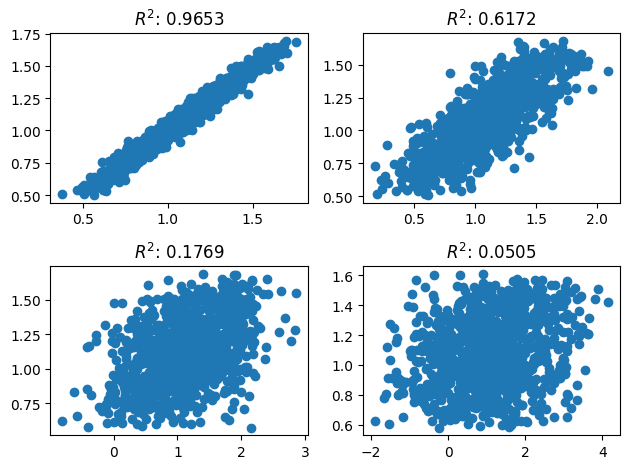

In [ ]:
nvars <- 2
nvalues <- 50
variables <- np.random.rand(nvars, nvalues)
exog = sm.add_constant(variables.T)
alpha <- np.random.rand()
betas <- np.random.rand(nvars)
fig, axes = plt.subplots(ncols=2, nrows=2)
axes = axes.flatten()
for i, err in enumerate([0.05, 0.2, 0.5, 1]):
  errors = st.norm.rvs(size=nvalues) * err
  y = alpha + betas@variables + errors
  reg_mod = sm.OLS(endog = y, exog = exog)
  fitted = reg_mod.fit()
  fval = fitted.fittedvalues
  axes[i].scatter(y,fval)
  axes[i].set_title(f"$R^2$: {fitted.rsquared:0.4f}")
fig.tight_layout()

In [ ]:
fitted.resid

array([ 1.04441879e+00,  1.09286033e+00, -1.47901795e-01, -4.35121338e-01,
       -5.29203595e-01, -1.26119052e-01, -6.26399260e-01, -6.19372330e-01,
        1.32566127e+00, -9.89967605e-01,  8.71862482e-01, -1.16978461e+00,
        5.89742503e-01, -1.67480550e-02,  1.24072172e+00,  3.61657334e-01,
        1.04509665e-01,  6.33569394e-01,  1.38058602e+00, -1.71076088e-01,
       -1.36852890e+00,  2.89177791e-01, -8.09722370e-01, -4.11511193e-01,
        7.60312686e-02, -7.34930152e-02, -6.81998684e-01,  4.74928800e-01,
       -1.36658873e-01,  4.90274699e-01, -1.44283200e-01,  5.42226847e-01,
        5.07865258e-01,  1.52458784e+00,  5.97211542e-01, -6.37680971e-01,
       -9.39573378e-01,  2.27668118e-02, -6.75488167e-01, -3.80059334e-01,
       -2.93536836e-01, -7.46809723e-01, -3.76363630e-01, -3.83015253e-01,
        7.41208033e-01, -8.44768817e-01,  1.78407073e-01, -1.12121790e+00,
        1.01342845e+00,  3.02399356e-01, -7.69082928e-01,  1.08427509e+00,
        2.54602510e-01, -

### Mínimos Cuadrados Ponderados.

En el caso de no cumplirse con la homocedacia
- es posible darle a cada observación un peso inversamente proporcional a la
  varianza para ese variable.
- Regresion por minimos cuadrados ponderados.
- Lo óptimo es conocer la varianza de los residuos
  - Muy dificil de conocer
- Se puede estimar a partir de los residuos.


## Ridge Regression

- Esta regresión es mucho más robusta a la presencia de variables
  explicativas correlacionadas (colineales).


```{r}
# En este ejemplo, vamos a modelar la 
# variable GNP.deflator como respuesta al
# resto de las variables aleatorias.
head(longley)
```



### Buscando colinearidad

Correlación:
- Medidas de variación conjunta entre dos variables aleatorias.
- Es una medida sin unidades que varía entre -1 y 1.
    - más fácil de trabajar e interpretar.


In [ ]:
import sklearn.datasets as datasets

iris = datasets.load_iris(as_frame=True)

iris_m = iris["frame"].iloc[:, :4].copy()
iris_m

# Queremos estimar sepal_length a patir de las otras variables.
iris_m.corr()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),1.000000,-0.117570,0.871754,0.817941
sepal width (cm),-0.117570,1.000000,-0.428440,-0.366126
petal length (cm),0.871754,-0.428440,1.000000,0.962865
petal width (cm),0.817941,-0.366126,0.962865,1.000000


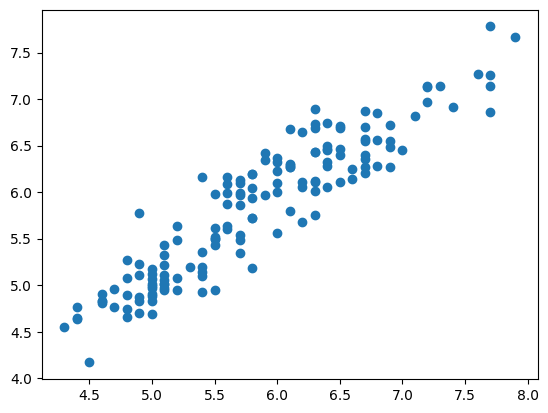

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold

# Defino los variables dependientes e independientes.
x = iris_m[["sepal width (cm)", "petal length (cm)", "petal width (cm)"]]
y = iris_m["sepal length (cm)"]

# Defino el modelo
model = Ridge()

# Hago el ajuste del modelo
fitted = model.fit(x, y)

plt.scatter(y, fitted.predict(x))